In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from transformers import AutoProcessor, CLIPModel
from PIL import Image


class Config:
    def __init__(self, epoch=0, n_epochs=300, dataset_name="amsl_rf", batch_size=24, lr=0.0001,
                 b1=0.5, b2=0.999, decay_epoch=100, n_cpu=8, img_height=256, img_width=256, 
                 channels=3, sample_interval=1000, checkpoint_interval=20, eval_interval=5):
        self.n_epochs = n_epochs
        self.dataset_name = dataset_name
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.channels = channels
        self.sample_interval = sample_interval

    def __str__(self):
        return str(self.__dict__)


# Initialize config
opt = Config()
print(opt)


# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((opt.img_height, opt.img_width), antialias=False),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Inverse transform (for visualization)
invTrans = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.],
                         std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                         std=[1., 1., 1.]),
    transforms.ToPILImage()
])


# CLIP model for conditioning
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
cond_model = CLIPModel.from_pretrained(
    "openai/clip-vit-base-patch32"
).cuda()


def get_embds(model, img, device, lamb=10.0, replicate=True):
    """
    Extract embeddings from CLIP for a batch of images.

    Args:
        model: CLIP model (already on device).
        img: Tensor of shape [B, C, H, W], normalized.
        device: str, e.g. "cuda".
        lamb: scaling factor.
        replicate: if True, repeat across 77 tokens for conditioning.

    Returns:
        Tensor [B, 77, D] if replicate else [B, D]
    """
    # Unwrap only once
    # model = accelerator.unwrap_model(model)
    model.eval()

    feats = []
    for image in img:  
        # Convert normalized tensor back to PIL for CLIP processor
        pil_img = invTrans(image.cpu())
        inputs = processor(images=pil_img, return_tensors="pt").to(device)
        with torch.no_grad():
            feat = model.get_image_features(**inputs)  # [1, D]
        feats.append(feat)

    feats = torch.cat(feats, dim=0)  # [B, D]

    if replicate:
        feats = feats.unsqueeze(1).repeat(1, 77, 1)  # [B, 77, D]

    return lamb * feats



/research/iprobe-shuklan3/anaconda3/envs/lcg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'n_epochs': 300, 'dataset_name': 'amsl_rf', 'batch_size': 24, 'img_height': 256, 'img_width': 256, 'channels': 3, 'sample_interval': 1000}


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# Download Model weights 

In [2]:

from huggingface_hub import hf_hub_download
model_path = hf_hub_download(
    repo_id="nitishshukla/pretrained-weights",
    filename="dcGAN-AMSL-RF.pth",
    local_dir="./pretrained"
)

# Load Model Weights

In [3]:
from models import Generator
import glob
generator = Generator(img_size=opt.img_width,in_channels=3,out_channels=6)
generator=torch.nn.DataParallel(generator)

generator.load_state_dict(torch.load(glob.glob('./pretrained/dcGAN-AMSL-RF.pth')[0]))
generator=generator.module.cuda()

# Demorph

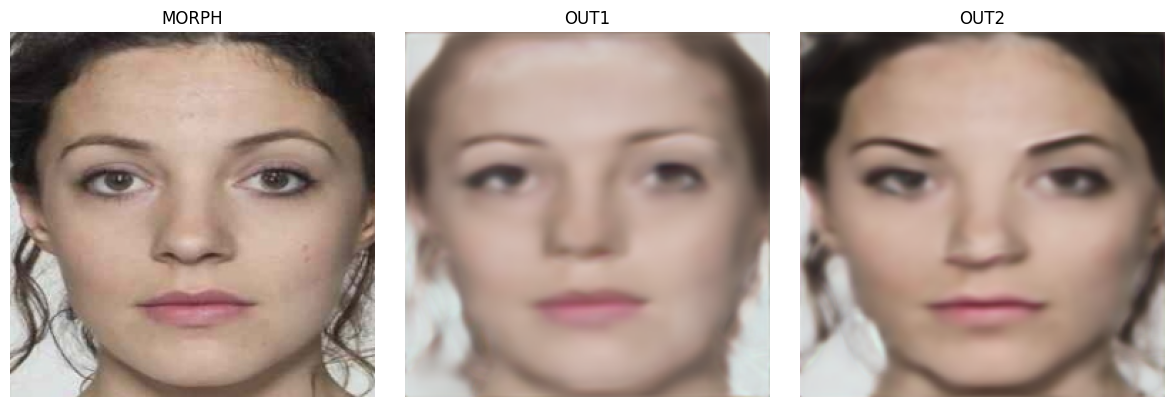

In [4]:
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image

def show_results(gen_out, invTrans):
    """
    Plot morph, out1, out2 horizontally with titles.
    """
    # gen_out is [1, C, H, W_concat]
    morph, out1, out2 = torch.chunk(gen_out[0], 3, dim=1)  # split along width

    images = [morph, out1, out2]
    titles = ["MORPH", "OUT1", "OUT2"]

    plt.figure(figsize=(12, 4))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 3, i + 1)
        plt.imshow(invTrans(img.cpu()))
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
def sample_from_path(img_path, generator, cond_model, transform, invTrans, device="cuda"):
    """Load an image, apply transform, generate, and return composite sample."""

    # Load and preprocess image
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)  # [1, C, H, W]

    # Get face embeddings from conditioning model
    face_embd = get_embds(cond_model, img_tensor, device)

    # Real A = morphed input
    real_A = Variable(img_tensor.type(torch.cuda.FloatTensor))

    # Forward pass generator
    fake_B = generator(real_A, face_embd)

    # Split into 2 faces
    fakeb1, fakeb2 = torch.split(fake_B.data, 3, 1)

    # Composite visualization (input + outputs)
    img_sample = torch.cat((real_A.data, fakeb1, fakeb2), -2)

    return img_sample


# Example usage
img_path = "./assets/sample_morph.jpg"  # <-- change to your image path
gen_out = sample_from_path(img_path, generator, cond_model, transform, invTrans)





show_results(gen_out, invTrans)
